In [30]:
import os
import time
import tensorflow as tf
from tensorflow.keras import layers 
import scipy.io as sio 
#from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import numpy as np

In [19]:
train_path = 'train.mat'

data = sio.loadmat('train.mat') 
train_x = data['x_data']
train_y = data['y_onehot'] 
class_name = data['class_name']
class_num = len(class_name)

test_data = sio.loadmat('test.mat')
test_x = test_data['x_data']
y_test_onehot = test_data['y_onehot']

print('data_num:', len(train_x))
print('class_name:', class_name)

data_num: 1705
class_name: ['scissors' 'rock    ' 'paper   ']


In [20]:
#def build_model(input_shape):
INPUT_SHAPE = (224, 224, 3)  
VAL_SPLIT = 0.2
BATCH = 32

base_model = MobileNetV3Small(input_shape=INPUT_SHAPE, 
                         weights='imagenet', 
                         include_top=False, 
                         include_preprocessing = True)
base_model.trainable = False

inputs = layers.Input(shape=INPUT_SHAPE)
preproccess = layers.RandomFlip()(inputs) 
x = base_model(preproccess, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
#x = layers.Dense(16, activation='relu')(x)#, kernel_regularizer=l2(0.01), activity_regularizer=l1(0.01))(x)
outputs = layers.Dense(class_num, activation='softmax')(x)#, kernel_regularizer=l2(0.01), activity_regularizer=l1(0.01))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["Accuracy"])
#return model
print(model.summary(show_trainable=True))

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         Y          
                                                                            
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    N          
 l)                                                                         
                                                                            
 global_average_pooling2d_2   (None, 576)              0         Y          
 (GlobalAveragePooling2D)                                                   
                                                                            
 dropout_2 (Dropout)         (None, 576)               0   

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=15, verbose=1,
                               restore_best_weights=True, 
                               mode='auto')

train_history = model.fit(x=train_x, y=train_y, 
                          validation_split=VAL_SPLIT, 
                          epochs=100, batch_size=BATCH, 
                          callbacks=[early_stopping])
complete_time=time.strftime("%Y%m%d_%H%M", time.localtime()) 
model.save('MobileNet_'+str(complete_time)+'.h5')

Epoch 1/100
43/43 [==============================] - 18s 375ms/step - loss: 1.0717 - Accuracy: 0.4707 - val_loss: 0.8763 - val_Accuracy: 0.5953
Epoch 2/100
43/43 [==============================] - 15s 358ms/step - loss: 0.8014 - Accuracy: 0.6496 - val_loss: 0.7139 - val_Accuracy: 0.7302
Epoch 3/100
43/43 [==============================] - 15s 351ms/step - loss: 0.6728 - Accuracy: 0.7133 - val_loss: 0.6255 - val_Accuracy: 0.7742
Epoch 4/100
43/43 [==============================] - 16s 370ms/step - loss: 0.6120 - Accuracy: 0.7595 - val_loss: 0.5809 - val_Accuracy: 0.7830
Epoch 5/100
43/43 [==============================] - 15s 356ms/step - loss: 0.5717 - Accuracy: 0.7918 - val_loss: 0.5502 - val_Accuracy: 0.8152
Epoch 6/100
43/43 [==============================] - 15s 360ms/step - loss: 0.5378 - Accuracy: 0.8050 - val_loss: 0.5209 - val_Accuracy: 0.8299
Epoch 7/100
43/43 [==============================] - 16s 363ms/step - loss: 0.5114 - Accuracy: 0.7991 - val_loss: 0.5150 - val_Accuracy:

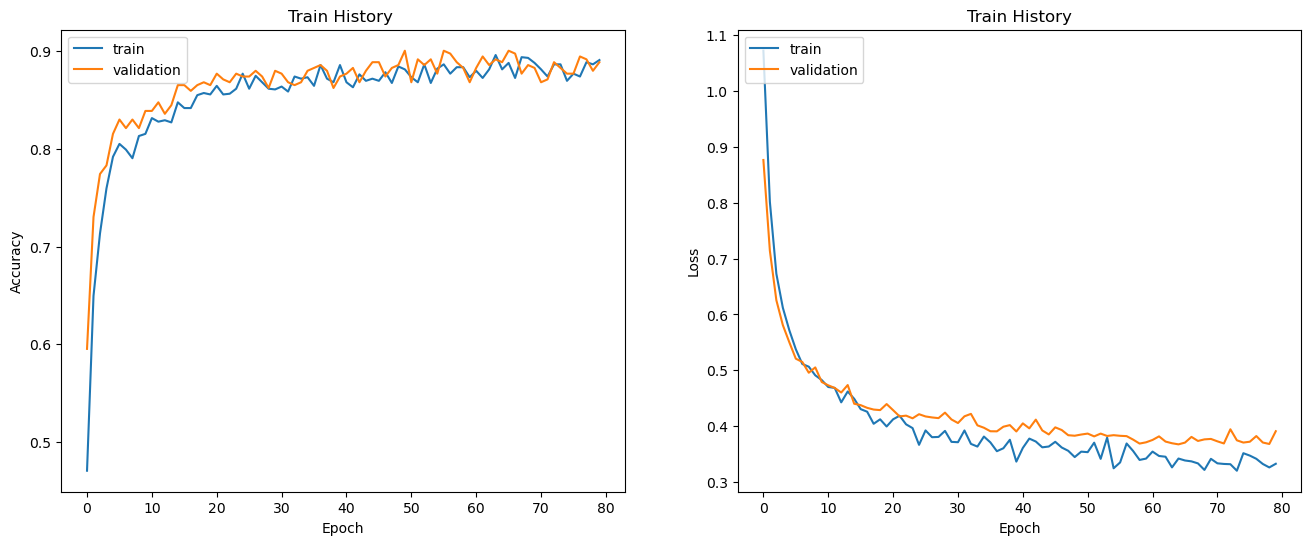

In [22]:
def show_train_history(cur_history):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    
    plt.subplot(121)
    plt.plot(cur_history["Accuracy"])
    plt.plot(cur_history["val_Accuracy"])
    plt.title("Train History ")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(cur_history["loss"])
    plt.plot(cur_history["val_loss"])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

show_train_history(train_history.history)

In [23]:
scores = model.evaluate(test_x, y_test_onehot)
#print(scores)

17/17 [==============================] - 5s 280ms/step - loss: 0.7989 - Accuracy: 0.6889


In [24]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_5
1 rescaling_2
2 Conv
3 Conv/BatchNorm
4 tf.__operators__.add_81
5 re_lu_64
6 tf.math.multiply_81
7 multiply_36
8 expanded_conv/depthwise/pad
9 expanded_conv/depthwise
10 expanded_conv/depthwise/BatchNorm
11 re_lu_65
12 expanded_conv/squeeze_excite/AvgPool
13 expanded_conv/squeeze_excite/Conv
14 expanded_conv/squeeze_excite/Relu
15 expanded_conv/squeeze_excite/Conv_1
16 tf.__operators__.add_82
17 re_lu_66
18 tf.math.multiply_82
19 expanded_conv/squeeze_excite/Mul
20 expanded_conv/project
21 expanded_conv/project/BatchNorm
22 expanded_conv_1/expand
23 expanded_conv_1/expand/BatchNorm
24 re_lu_67
25 expanded_conv_1/depthwise/pad
26 expanded_conv_1/depthwise
27 expanded_conv_1/depthwise/BatchNorm
28 re_lu_68
29 expanded_conv_1/project
30 expanded_conv_1/project/BatchNorm
31 expanded_conv_2/expand
32 expanded_conv_2/expand/BatchNorm
33 re_lu_69
34 expanded_conv_2/depthwise
35 expanded_conv_2/depthwise/BatchNorm
36 re_lu_70
37 expanded_conv_2/project
38 expanded_conv_2/project/Batc

In [25]:
#model = tf.keras.models.load_model('MobileNet_20240830_1610.h5')

for layer in model.layers[-8:]:
   layer.trainable = True

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, verbose=1,
                               restore_best_weights=True, 
                               mode='auto')

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=["Accuracy"])
train_history = model.fit(x=train_x, y=train_y, 
                          validation_split=VAL_SPLIT, 
                          epochs=20, batch_size=BATCH, 
                          callbacks=[early_stopping])

complete_time=time.strftime("%Y%m%d_%H%M", time.localtime()) 
model.save('MobileNet_fineturn_'+str(complete_time)+'.h5')

Epoch 1/20
43/43 [==============================] - 174s 4s/step - loss: 0.3203 - Accuracy: 0.8959 - val_loss: 0.3619 - val_Accuracy: 0.9062
Epoch 2/20
43/43 [==============================] - 177s 4s/step - loss: 0.3008 - Accuracy: 0.9062 - val_loss: 0.3547 - val_Accuracy: 0.9150
Epoch 3/20
43/43 [==============================] - 181s 4s/step - loss: 0.3063 - Accuracy: 0.8952 - val_loss: 0.3537 - val_Accuracy: 0.9179
Epoch 4/20
43/43 [==============================] - 178s 4s/step - loss: 0.2813 - Accuracy: 0.9069 - val_loss: 0.3349 - val_Accuracy: 0.9150
Epoch 5/20
43/43 [==============================] - 182s 4s/step - loss: 0.2774 - Accuracy: 0.9128 - val_loss: 0.3289 - val_Accuracy: 0.9091
Epoch 6/20
43/43 [==============================] - 187s 4s/step - loss: 0.2641 - Accuracy: 0.9120 - val_loss: 0.3260 - val_Accuracy: 0.9120
Epoch 7/20
43/43 [==============================] - 182s 4s/step - loss: 0.2593 - Accuracy: 0.9069 - val_loss: 0.3307 - val_Accuracy: 0.9267
Epoch 8/20
43

In [28]:
#evaluate
scores = model.evaluate(test_x, y_test_onehot)
print(scores)
#print('Test loss:', scores[1],' Test W1 accuracy:', scores[5])

17/17 [==============================] - 4s 262ms/step - loss: 0.7593 - Accuracy: 0.7519
[0.7593004107475281, 0.7518518567085266]


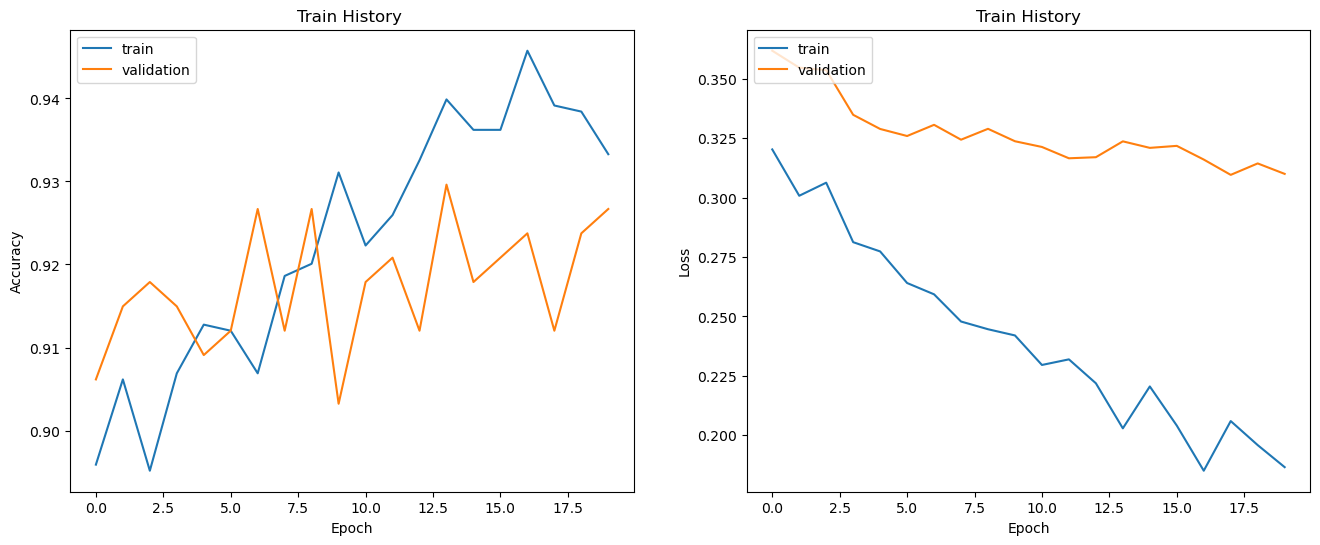

In [29]:
show_train_history(train_history.history)